In [40]:
import json
import pandas as pd
import dash
from dash import dcc, html, dash_table

In [73]:
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

def load_metrics_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_metrics_table(metrics_data: dict, num_airplanes: dict) -> pd.DataFrame:
    rows = []

    for solver, records in metrics_data.items():
        for rec in records:
            file = rec.get("file", "unknown")
            n_planes = num_airplanes.get(file, "—")
            num_runways = rec.get("num_runways", 1)
            strategy = rec.get("strategy", "—")

            exec_time = (
                rec.get("execution_time") or
                rec.get("total_time") or
                rec.get("cp_time") or
                rec.get("mip_time") or
                None
            )

            memory = (
                rec.get("memory_usage_MB") or
                rec.get("memory_usage") or
                rec.get("memory_start_MB") or
                None
            )

            penalty = (
                rec.get("total_penalty") or
                rec.get("best_objective_bound") or
                rec.get("total_best_objective_bound")
            )
            if penalty is not None:
                penalty = round(penalty)

            num_vars = rec.get("num_variables") or rec.get("cp_num_variables")
            num_cons = rec.get("num_constraints") or rec.get("cp_num_constraints")

            num_branches = (
                rec.get("num_branch_and_bound_nodes") or
                rec.get("num_branches") or
                rec.get("cp_num_branches")
            )

            row = {
                "Dataset": file,
                "#Planes": n_planes,
                "#Runways": num_runways,
                "Solver": solver,
                "Strategy": strategy,
                "Time (s)": exec_time,
                "Memory (MB)": memory,
                "Penalty / Obj": penalty,
                "#Variables": num_vars,
                "#Constraints": num_cons,
                "#Branches": num_branches,
                "Converged": rec.get("converged", rec.get("solution_status", "—")),
                "Num Conflicts": rec.get("num_conflicts", rec.get("cp_num_conflicts", "—")),
                "Num Booleans": rec.get("num_booleans", rec.get("cp_num_booleans","—")),
                "Num Iterations": rec.get("num_iterations", "—"),
                "MIP Num Calls": rec.get("mip_num_calls", "—")
            }

            rows.append(row)

    df = pd.DataFrame(rows)

    df["Solver"] = df["Solver"].replace({
        "MIP Multiple Large Datasets": "MIP Multiple",
        "CP Multiple Large Datasets": "CP Multiple",
        "Hybrid Large Datasets": "Hybrid"
    })

    return df


# Metrics table

## Static

In [62]:
def group_dataset_rows(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    for col in ["Dataset", "#Planes"]:
        df[col] = df[col].where(df[col].ne(df[col].shift()), "")

    return df

def style_metrics_table(df: pd.DataFrame, dataset_order: list):
    df = df.copy()

    solver_order = ["MIP Single", "MIP Multiple", "CP Single", "CP Multiple", "Hybrid"]

    df["Dataset"] = pd.Categorical(
        df["Dataset"],
        categories=dataset_order,
        ordered=True
    )

    df["Solver"] = pd.Categorical(
        df["Solver"],
        categories=solver_order,
        ordered=True
    )

    df = df.sort_values(
        ["Dataset", "Solver", "#Runways"],
        kind="stable"
    )

    df["Dataset"] = df["Dataset"].astype(str)

    df = group_dataset_rows(df)

    # Styling
    return (
        df
        .style
        .format({
            "Time (s)": "{:.3f}",
            "Memory (MB)": "{:.3f}",
            "Penalty / Obj": "{:.2f}",
        })
        .set_properties(**{
            "text-align": "center",
            "font-size": "11pt",
            "color": "#333333",
        })
        .set_table_styles([
            {
                "selector": "th",
                "props": [
                    ("font-weight", "bold"),
                    ("background-color", "#024253"),
                    ("color", "white"),
                    ("text-align", "center"),
                    ("border", "1px solid #BDBDBD"),
                ],
            },
            {
                "selector": "td",
                "props": [
                    ("padding", "6px"),
                    ("background-color", "#ECEEEE"),
                    ("border", "1px solid #DDDDDD"),
                ],
            },
        ])
        .hide(axis="index")
    )

metrics_data = load_metrics_json("results/metrics.json")

df = build_metrics_table(metrics_data, NUM_AIRPLANES)

dataset_order = list(NUM_AIRPLANES.keys())

styled_df = style_metrics_table(df, dataset_order)
styled_df


Dataset,#Planes,#Runways,Solver,Strategy,Time (s),Memory (MB),Penalty / Obj,#Variables,#Constraints,#Branches,Converged,Num Conflicts,Num Booleans,Num Iterations,MIP Num Calls
airland1.txt,10,1,MIP Single,—,0.197,0.001,700.00,120,205,25.000000,—,nan,nan,nan,nan
,,1,MIP Multiple,—,0.087,0.002,700.00,220,305,22.000000,—,nan,nan,nan,nan
,,2,MIP Multiple,—,0.082,0.000,90.00,230,350,5.000000,—,nan,nan,nan,nan
,,3,MIP Multiple,—,0.092,0.000,nan,240,395,23.000000,—,nan,nan,nan,nan
,,1,CP Single,Automatic Search,0.018,0.008,700.00,75,130,nan,OPTIMAL,0.000000,0.000000,nan,nan
,,1,CP Single,Fixed Search,0.036,0.007,700.00,75,130,nan,OPTIMAL,0.000000,0.000000,nan,nan
,,1,CP Single,Portfolio Search,0.020,0.007,700.00,75,130,nan,OPTIMAL,0.000000,0.000000,nan,nan
,,1,CP Single,LP Search,0.026,0.007,700.00,75,130,26.000000,OPTIMAL,0.000000,45.000000,nan,nan
,,1,CP Multiple,Automatic Search,0.022,0.017,700.00,130,310,106.000000,OPTIMAL,0.000000,58.000000,nan,nan
,,1,CP Multiple,Fixed Search,0.020,0.017,700.00,130,310,nan,OPTIMAL,0.000000,45.000000,nan,nan


## With Filters

In [74]:
import dash
from dash import dcc, html, dash_table
import pandas as pd

metrics_data = load_metrics_json("results/metrics.json")
df = build_metrics_table(metrics_data, NUM_AIRPLANES)

solver_order = ["MIP Single", "MIP Multiple", "CP Single", "CP Multiple", "Hybrid"]
dataset_order = list(NUM_AIRPLANES.keys())

df["Dataset"] = pd.Categorical(df["Dataset"], categories=dataset_order, ordered=True)
df["Solver"] = pd.Categorical(df["Solver"], categories=solver_order, ordered=True)
df = df.sort_values(["Dataset", "Solver", "#Runways"], kind="stable").reset_index(drop=True)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H3("Interactive Metrics Table"),

    html.Div([
        html.Label("Filter by Dataset:"),
        dcc.Dropdown(
            id="dataset-filter",
            options=[{"label": d, "value": d} for d in dataset_order],
            multi=True,
            placeholder="Select dataset(s)"
        ),
    ], style={"width": "45%", "display": "inline-block", "padding-right": "20px"}),

    html.Div([
        html.Label("Filter by Solver:"),
        dcc.Dropdown(
            id="solver-filter",
            options=[{"label": s, "value": s} for s in solver_order],
            multi=True,
            placeholder="Select solver(s)"
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Br(),

    dash_table.DataTable(
        id="metrics-table",
        columns=[{"name": c, "id": c} for c in df.columns],
        data=df.to_dict("records"),
        style_cell={
            'textAlign': 'center',
            'padding': '5px',
            'minWidth': '80px',
            'width': '80px',
            'maxWidth': '200px',
            'whiteSpace': 'normal',
        },
        style_header={
            'backgroundColor': '#024253',
            'color': 'white',
            'fontWeight': 'bold',
            'textAlign': 'center'
        },
        style_data={'backgroundColor': '#ECEEEE', 'color': '#333333'},
        style_table={
            'overflowX': 'auto',
            'maxWidth': '100%',
            'border': '1px solid #DDDDDD'
        },
        page_size=20,
        sort_action="native",
    )
], style={"backgroundColor": "white", "padding": "20px"})

@app.callback(
    dash.dependencies.Output("metrics-table", "data"),
    [
        dash.dependencies.Input("dataset-filter", "value"),
        dash.dependencies.Input("solver-filter", "value"),
    ]
)
def update_table(selected_datasets, selected_solvers):
    filtered = df.copy()
    if selected_datasets:
        filtered = filtered[filtered["Dataset"].isin(selected_datasets)]
    if selected_solvers:
        filtered = filtered[filtered["Solver"].isin(selected_solvers)]

    numeric_cols = filtered.select_dtypes(include=["number"]).columns
    filtered[numeric_cols] = filtered[numeric_cols].fillna(0)

    return filtered.to_dict("records")


if __name__ == "__main__":
    app.run(debug=True)


# Plots

In [54]:
metrics_data = load_metrics_json("results/metrics.json")
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

df = build_metrics_table(metrics_data, NUM_AIRPLANES)

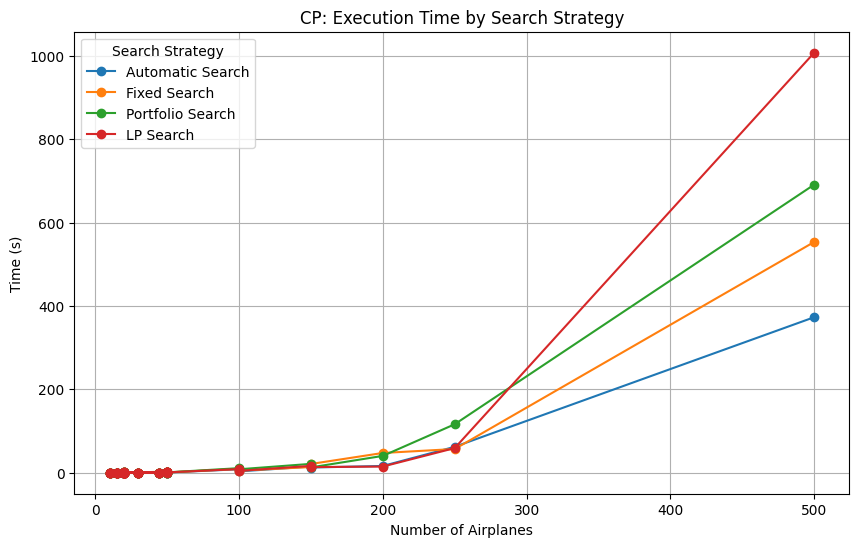

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Filters only CP solver data
df_cp = df[df["Solver"].str.contains("CP")].copy()

# Converte "#Planes" para numérico
df_cp["#Planes"] = pd.to_numeric(df_cp["#Planes"])

# Color mapping por strategy
strategies = df_cp["Strategy"].unique()
colors = plt.cm.tab10.colors
color_map = {s: colors[i % len(colors)] for i, s in enumerate(strategies)}

plt.figure(figsize=(10, 6))
for s in strategies:
    subset = df_cp[df_cp["Strategy"] == s]
    plt.plot(subset["#Planes"], subset["Time (s)"], marker='o', color=color_map[s], label=s)

plt.xlabel("Number of Airplanes")
plt.ylabel("Time (s)")
plt.title("CP: Execution Time by Search Strategy")
plt.legend(title="Search Strategy")
plt.grid(True)
plt.show()


/tmp/ipykernel_202904/422056387.py:8: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/tmp/ipykernel_202904/422056387.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



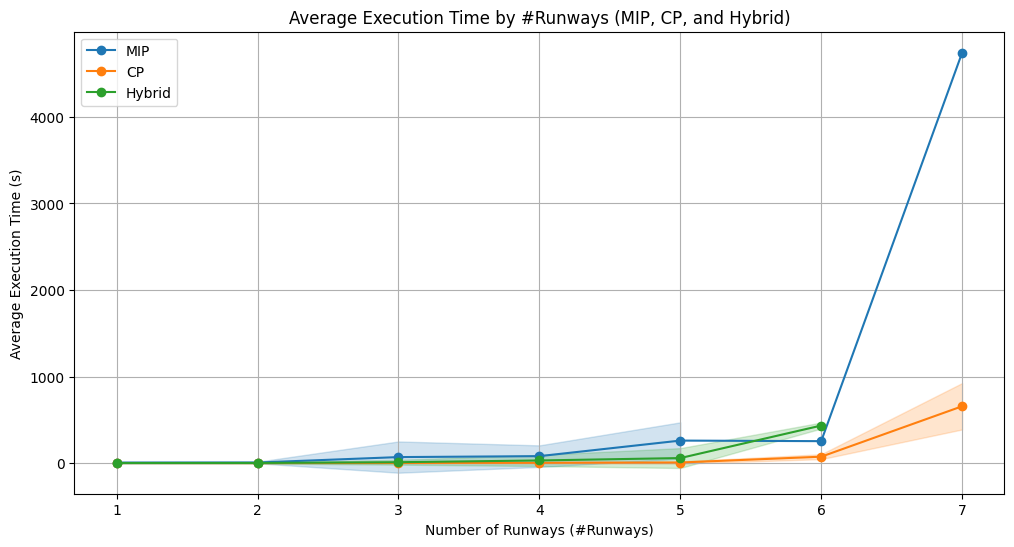

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter only solvers of interest and unify names
df_selected = df[df["Solver"].str.contains("MIP|CP|Hybrid")].copy()

df_selected["Solver"] = df_selected["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

df_selected["#Planes"] = pd.to_numeric(df_selected["#Planes"])
df_selected["#Runways"] = pd.to_numeric(df_selected["#Runways"])

summary = df_selected.groupby(["Solver", "#Runways"]).agg(
    Time_mean=("Time (s)", "mean"),
    Time_std=("Time (s)", "std"),
    Penalty_mean=("Penalty / Obj", "mean"),
    Penalty_std=("Penalty / Obj", "std")
).reset_index()

colors = {"MIP": "tab:blue", "CP": "tab:orange", "Hybrid": "tab:green"}

# Plot mean Time ± standard deviation
plt.figure(figsize=(12, 6))
for solver in summary["Solver"].unique():
    data = summary[summary["Solver"] == solver]
    plt.plot(data["#Runways"], data["Time_mean"], marker='o', label=solver, color=colors[solver])
    plt.fill_between(
        data["#Runways"],
        data["Time_mean"] - data["Time_std"],
        data["Time_mean"] + data["Time_std"],
        alpha=0.2,
        color=colors[solver]
    )

plt.xlabel("Number of Runways (#Runways)")
plt.ylabel("Average Execution Time (s)")
plt.title("Average Execution Time by #Runways (MIP, CP, and Hybrid)")
plt.grid(True)
plt.legend()
plt.show()
